In [1]:
import math
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import collections as col
import re
import random
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
#from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
#from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import auc,roc_curve

In [2]:
def load_data(train='Yes', test='No', validation='No'):
	"""Loads and returns datasets as required
	   Return empty lst for if 'No'
	"""
	if train=='Yes':
		df_train = pd.read_csv('dataset/train.csv', sep=',')
	else:
		df_train = []

	if test=='Yes':
		df_test = pd.read_csv('dataset/test.csv', sep=',')
	else:
		df_test = []

	if validation=='Yes':
		df_validation = pd.read_csv('dataset/validation.csv', sep=',')
	else:
		df_validation = []
	
	print('Data loaded', len(df_train), len(df_test), len(df_validation))
	return df_train, df_test, df_validation

In [3]:
df_train, df_test, df_validation= load_data('No', 'No', 'Yes')

Data loaded 0 0 299749


In [4]:
average = 0.0007539649884458758

In [68]:
max(df_model['pCTR'])

0.98959410829954397

In [72]:
df_temp= pd.DataFrame()
df_temp= pd.read_csv('pCTR_0.82.csv')
df_temp.columns = ['index', 'pCTR_82']

df_model= pd.DataFrame()
df_model = df_validation
df_model['pCTR'] = df_temp['pCTR_82']
df_model['pCTR_norm'] = df_model['pCTR'].values/ average

df_model= df_model.drop(['weekday', 'hour', 'logtype', 'userid', 'useragent',
       'IP', 'region', 'city', 'adexchange', 'domain', 'url', 'urlid',
       'slotid', 'slotwidth', 'slotheight', 'slotvisibility', 'slotformat',
       'slotprice', 'creative', 'keypage',
       'advertiser', 'usertag'], axis=1)


In [87]:
len(df_model[(df_model['click']== 0) & (df_model['pCTR_norm']> 1000)])

20

In [80]:
df_model_click= df_model[df_model['click']== 1]
df_model_clickb= df_model[(df_model['click']== 1) & (df_model['pCTR_norm']> 0.845)]
df_model_nclick= df_model[df_model['click']== 0]
df_model_nclickb= df_model[(df_model['click']== 0) & (df_model['pCTR_norm']> 0.845)]

In [83]:
max(df_model['pCTR_norm'])

1312.5199756813151

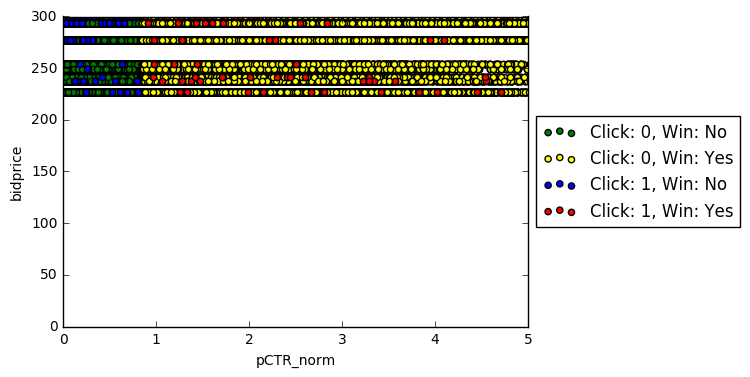

In [100]:
ax =df_model_nclick.plot.scatter(x='pCTR_norm', y='payprice', color='Green', label='Click: 0, Win: No')
df_model_nclickb.plot.scatter(x='pCTR_norm', y='payprice', color='Yellow', label='Click: 0, Win: Yes', ax= ax)
df_model_click.plot.scatter(x='pCTR_norm', y='payprice', color='Blue', label='Click: 1, Win: No', ax= ax)
df_model_clickb.plot.scatter(x='pCTR_norm', y='payprice', color='Red', label='Click: 1, Win: Yes', ax= ax)

axes = plt.gca()
axes.set_xlim([0, 5])
axes.set_ylim([0, 300])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [40]:
def constant_bid(baseline_bid, pCTR_norm= None, c= None, lambd= None):
    con_bid= baseline_bid
    return con_bid

def random_bid(baseline_bid, pCTR_norm= None, c= None, lambd= None):
    ran_bid= np.random.randint(-1, baseline_bid)
    return ran_bid

def linear_bid(baseline_bid, pCTR_norm, c= None, lambd= None):
    lin_bid= baseline_bid* (pCTR_norm)
    return lin_bid

def linear_bid_2(baseline_bid, pCTR_norm, c= None, lambd= None):
    lin_bid= baseline_bid* (pCTR_norm** 2)
    return lin_bid

def w_bid(baseline_bid, pCTR_norm, c, lambd):
    w_b= b_bid(baseline_bid, pCTR_norm, c, lambd)/ (b_bid(baseline_bid, pCTR_norm, c, lambd)+ c)
    return w_b

def b_bid(baseline_bid, pCTR_norm, c, lambd):
    nlin_bid= (np.sqrt(((c/ lambd)* pCTR_norm)+ (c**2))- c)/ (\
              (np.sqrt(((c/ lambd)* pCTR_norm)+ (c**2))- c)+ c)* baseline_bid
    return nlin_bid

def gate_bid(baseline_bid, pCTR_norm, c, lambd):
    if pCTR_norm> baseline_bid:
        return 300
    else:
        return 0
    
def gate_bid_agg(baseline_bid, pCTR_norm, c, lambd, perc_bud, perc_imp):
    if pCTR_norm> (baseline_bid*(perc_imp/ perc_bud)):
        return 300
    else:
        return 0

In [53]:
def run_model(df_model, baseline_bid, bid_strat, c= 20, lambd= 0.0001):
    win_count= 0
    win_click_count= 0
    loss_count= 0
    loss_click_count= 0
    total_cost= 0
    budget= 250000
    total_imp = 299749
    perc_bud= 1
    perc_imp= 1
    count= 1
    
    for index, row in df_model.iterrows():
        if row['payprice']< bid_strat(baseline_bid, row['pCTR_norm'], c, lambd, perc_bud, perc_imp):
            win_count+= 1
            if row['click']== 1:
                win_click_count+= 1
            total_cost+= row['payprice']
            if total_cost> budget:
                break
        else:
            loss_count+= 1
            if row['click']== 1:
                loss_click_count+= 1
        perc_bud = 1- (total_cost/ budget)
        perc_imp = 1- (count/ total_imp)
        count+= 1
                
    try:
        CTR= (win_click_count/ win_count)
    except:
        CTR= 0
    
    return [bid_strat.__name__, baseline_bid, win_count, win_click_count, loss_count, loss_click_count, CTR, total_cost]

In [54]:
try:
    df_results
except:
    df_results= pd.DataFrame()

for i in range(25, 35, 5):
    results= run_model(df_validation, i, gate_bid_agg)
    if len(df_results)== 0:
        df_results = pd.DataFrame([results], columns=('bid_strat', 'baseline_bid', 'win_count', 'win_click_count', 'loss_count', 'loss_click_count', 'CTR', 'total_cost'))
    else:
        df_temp = pd.DataFrame()
        df_temp = pd.DataFrame([results], columns=('bid_strat', 'baseline_bid', 'win_count', 'win_click_count', 'loss_count', 'loss_click_count', 'CTR', 'total_cost'))
        df_results= df_results.append(df_temp)

In [56]:
df_results[df_results.bid_strat=='gate_bid']

,bid_strat,baseline_bid,win_count,win_click_count,loss_count,loss_click_count,CTR,total_cost
0,gate_bid,0,3176,4,1,0,0.001259,250010
0,gate_bid,1,2770,11,12481,4,0.003971,250061
0,gate_bid,2,2777,21,29262,17,0.007562,250047
0,gate_bid,3,2852,25,46969,24,0.008766,250078
0,gate_bid,4,2947,28,63086,33,0.009501,250027
0,gate_bid,5,2938,33,78533,39,0.011232,250006
0,gate_bid,6,2749,38,100524,49,0.013823,250007
0,gate_bid,7,2564,39,128175,65,0.015211,250004
0,gate_bid,8,2477,40,151016,80,0.016149,250085
0,gate_bid,9,2448,43,174228,95,0.017565,250068


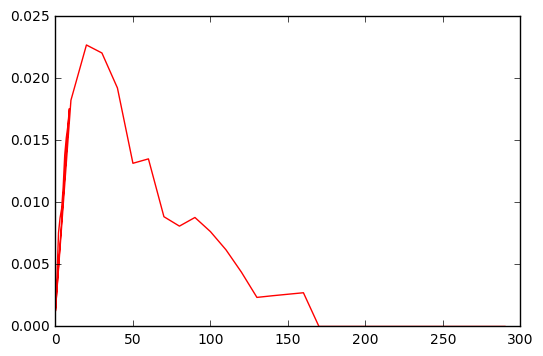

In [27]:
df_table = df_results[df_results.bid_strat=='gate_bid']

x = df_table.baseline_bid.values
a = df_table.CTR.values
b = df_table.total_cost.values
c = df_table.win_count.values

plt.plot(x,a,'r') # plotting t,a separately 
#plt.plot(x,b,'b') # plotting t,b separately 
#plt.plot(x,c,'g') # plotting t,c separately 
plt.show()

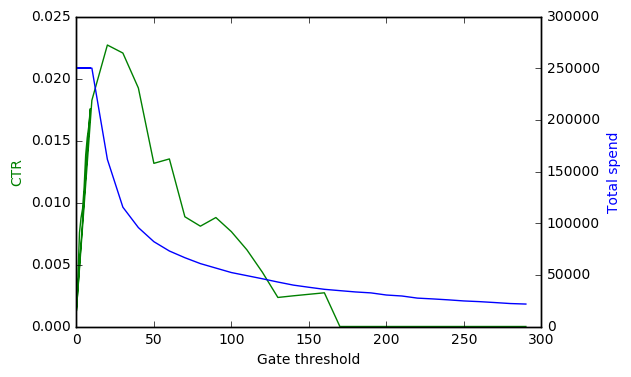

In [38]:
x = df_table.baseline_bid.values
a = df_table.CTR.values
b = df_table.win_count.values
c = df_table.total_cost.values

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, a, 'g-')
ax2.plot(x, c, 'b-')


ax1.set_xlabel('Gate threshold')
ax1.set_ylabel('CTR', color='g', )
ax2.set_ylabel('Total spend', color='b')

plt.show()

In [30]:
df_table.baseline_bid.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,   0,  10,  20,
        30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150,
       160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290])